In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')



Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz


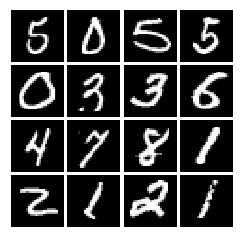

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    negative_part = tf.nn.relu(-x)
    x = tf.nn.relu(x)
    x -= alpha * negative_part
    return x

In [5]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    
    
    return D_loss, G_loss

In [11]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [6]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    
    
    return D_solver, G_solver

In [ ]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1,)

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        net = tf.reshape(x,[-1,28,28,1])
        net = tf.layers.conv2d(net,32,[5,5],padding="valid",activation=leaky_relu)
        net = tf.layers.max_pooling2d(net,2,2,padding="valid")
        net = tf.layers.conv2d(net,64,[5,5],padding="valid",activation=leaky_relu)
        net = tf.layers.max_pooling2d(net,2,2,padding="valid")
        net = tf.reshape(net,[-1,4*4*64])
        net = tf.layers.dense(net,4*4*64,activation=leaky_relu)
        logits = tf.layers.dense(net,1)
        return logits

In [8]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        net = tf.layers.dense(z,1024,activation=tf.nn.relu)
        net = tf.layers.batch_normalization(net,training=True)
        net = tf.layers.dense(net,7*7*128,activation=tf.nn.relu)
        net = tf.layers.batch_normalization(net,training=True)
        net = tf.reshape(net,[-1,7,7,128])
        net = tf.layers.conv2d_transpose(net,64,[4,4],strides=2,padding="same",activation=tf.nn.relu)
        net = tf.layers.batch_normalization(net,training=True)
        net = tf.layers.conv2d_transpose(net,1,[4,4],strides=2,padding="same",activation=tf.tanh)
        img = tf.reshape(net,[-1,784])
        return img

In [16]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)

D_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
with tf.control_dependencies(D_extra_update_ops):
    D_train_step = D_solver.minimize(D_loss, var_list=D_vars)

G_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')
with tf.control_dependencies(G_extra_update_ops):
    G_train_step = G_solver.minimize(G_loss, var_list=G_vars) 

    
# D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
# G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

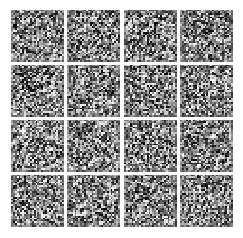


Iter: 0, D: 1.408, G:0.6847
Iter: 50, D: 0.6858, G:1.14
Iter: 100, D: 0.8704, G:0.7812
Iter: 150, D: 0.9218, G:1.023
Iter: 200, D: 1.327, G:1.458


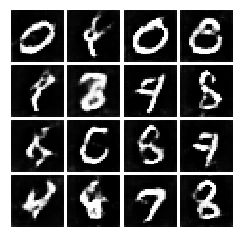


Iter: 250, D: 1.086, G:0.9271
Iter: 300, D: 1.14, G:0.8783
Iter: 350, D: 1.155, G:0.6643
Iter: 400, D: 1.203, G:1.426
Iter: 450, D: 1.108, G:1.51


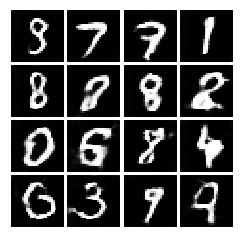


Iter: 500, D: 1.229, G:1.246
Iter: 550, D: 1.088, G:0.8066
Iter: 600, D: 1.206, G:1.004
Iter: 650, D: 1.109, G:1.101
Iter: 700, D: 1.244, G:1.553


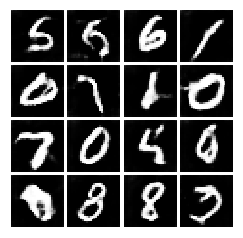


Iter: 750, D: 1.525, G:0.5492
Iter: 800, D: 1.17, G:0.9005
Iter: 850, D: 1.176, G:0.651
Iter: 900, D: 1.061, G:1.193
Iter: 950, D: 1.297, G:0.335


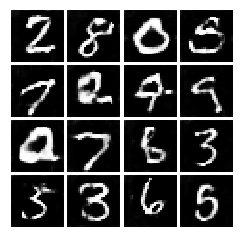


Iter: 1000, D: 1.243, G:0.7676
Iter: 1050, D: 1.45, G:1.959
Iter: 1100, D: 1.102, G:0.8525
Iter: 1150, D: 1.172, G:0.8776
Iter: 1200, D: 1.266, G:1.405


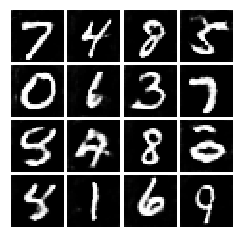


Iter: 1250, D: 1.234, G:0.952
Iter: 1300, D: 1.215, G:0.7403
Iter: 1350, D: 1.039, G:1.14
Iter: 1400, D: 1.059, G:1.574
Iter: 1450, D: 1.014, G:0.9554


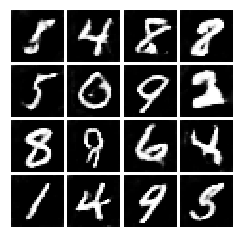


Iter: 1500, D: 1.065, G:0.9085
Iter: 1550, D: 1.083, G:0.7807
Iter: 1600, D: 1.06, G:0.8289
Iter: 1650, D: 1.1, G:1.047
Iter: 1700, D: 1.749, G:0.9315


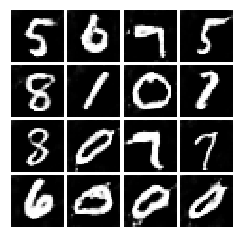


Iter: 1750, D: 1.037, G:0.7234
Iter: 1800, D: 1.119, G:1.845
Iter: 1850, D: 1.284, G:1.529
Iter: 1900, D: 1.168, G:1.253
Iter: 1950, D: 1.034, G:1.149


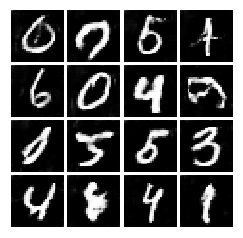


Iter: 2000, D: 0.9819, G:0.9472
Iter: 2050, D: 1.071, G:1.68
Iter: 2100, D: 1.017, G:1.945
Iter: 2150, D: 1.093, G:1.513
Iter: 2200, D: 1.039, G:1.054


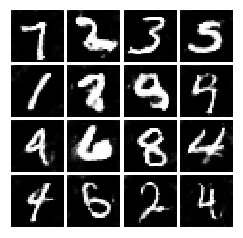


Iter: 2250, D: 1.054, G:0.6162
Iter: 2300, D: 1.016, G:1.122
Iter: 2350, D: 0.9028, G:1.545
Iter: 2400, D: 1.151, G:1.71
Iter: 2450, D: 0.954, G:0.9779


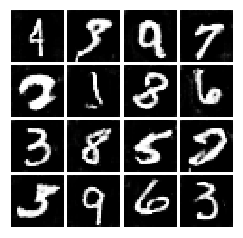


Iter: 2500, D: 0.9607, G:1.313
Iter: 2550, D: 1.068, G:1.96
Iter: 2600, D: 1.055, G:1.46
Iter: 2650, D: 0.999, G:1.029
Iter: 2700, D: 0.9192, G:1.189


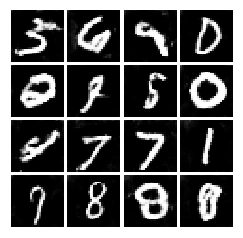


Iter: 2750, D: 1.01, G:1.096
Iter: 2800, D: 0.8589, G:1.218
Iter: 2850, D: 1.017, G:1.574
Iter: 2900, D: 1.01, G:1.397
Iter: 2950, D: 0.9781, G:0.9533


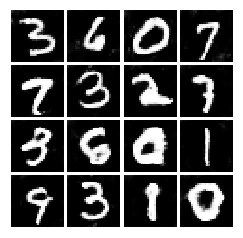


Iter: 3000, D: 0.957, G:1.271
Iter: 3050, D: 1.028, G:0.5292
Iter: 3100, D: 0.8542, G:1.403
Iter: 3150, D: 1.02, G:1.925
Iter: 3200, D: 0.9774, G:0.7378


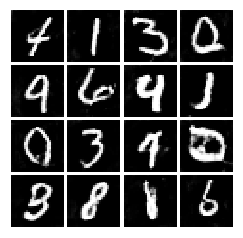


Iter: 3250, D: 0.9208, G:1.254
Iter: 3300, D: 0.8913, G:1.108
Iter: 3350, D: 0.8533, G:1.297
Iter: 3400, D: 0.9014, G:1.28
Iter: 3450, D: 0.8511, G:0.7093


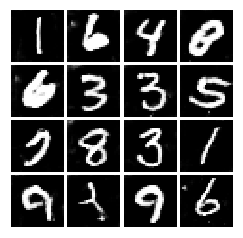


Iter: 3500, D: 0.9273, G:1.358
Iter: 3550, D: 0.8485, G:1.434
Iter: 3600, D: 0.8042, G:1.078
Iter: 3650, D: 0.9247, G:0.6277
Iter: 3700, D: 0.8221, G:1.406


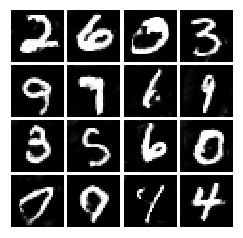


Iter: 3750, D: 0.8951, G:0.958
Iter: 3800, D: 0.8323, G:1.312
Iter: 3850, D: 1.002, G:0.9776
Iter: 3900, D: 0.8356, G:1.399
Iter: 3950, D: 0.9425, G:1.267


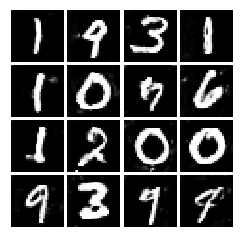


Iter: 4000, D: 0.7907, G:1.328
Iter: 4050, D: 0.8472, G:1.362
Iter: 4100, D: 0.8351, G:1.895
Iter: 4150, D: 1.106, G:0.7174
Iter: 4200, D: 0.758, G:1.379


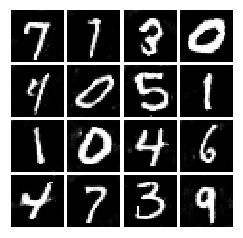


Iter: 4250, D: 0.8223, G:1.225
Final images


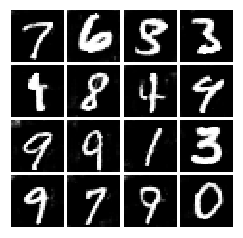

In [17]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)